I think the CUAD dataset is ok, the only issue is that there are empty answers. We could clean the data for example.

In [1]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install accelerate
# To run the training on TPU, you will need to uncomment the following line:
# !pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!apt install git-lfs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 8.3 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 3.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-many

In [2]:
from datasets import load_dataset

raw_datasets = load_dataset("cuad")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/22450 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/4182 [00:00<?, ? examples/s]

In [3]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 22450
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 4182
    })
})

Now we **CLEAN the DATA**

In [4]:
from datasets import DatasetDict
# Define a filtering function
def filter_empty_answers(example):
    return example['answers']['text'] != [] and example['answers']['answer_start'] != []

# Filter out examples with empty "text" and "answer_start" fields for train split
filtered_train_dataset = raw_datasets['train'].filter(filter_empty_answers)

# Filter out examples with empty "text" and "answer_start" fields for test split
filtered_test_dataset = raw_datasets['test'].filter(filter_empty_answers)

# Create a new DatasetDict WITHOUT the filtered examples
filtered_datasets = DatasetDict({                                  # RENAME LATER TO filtered_datasets
    'train': filtered_train_dataset,
    'test': filtered_test_dataset
})

Filter:   0%|          | 0/22450 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4182 [00:00<?, ? examples/s]

In [5]:
filtered_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 11180
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 1244
    })
})

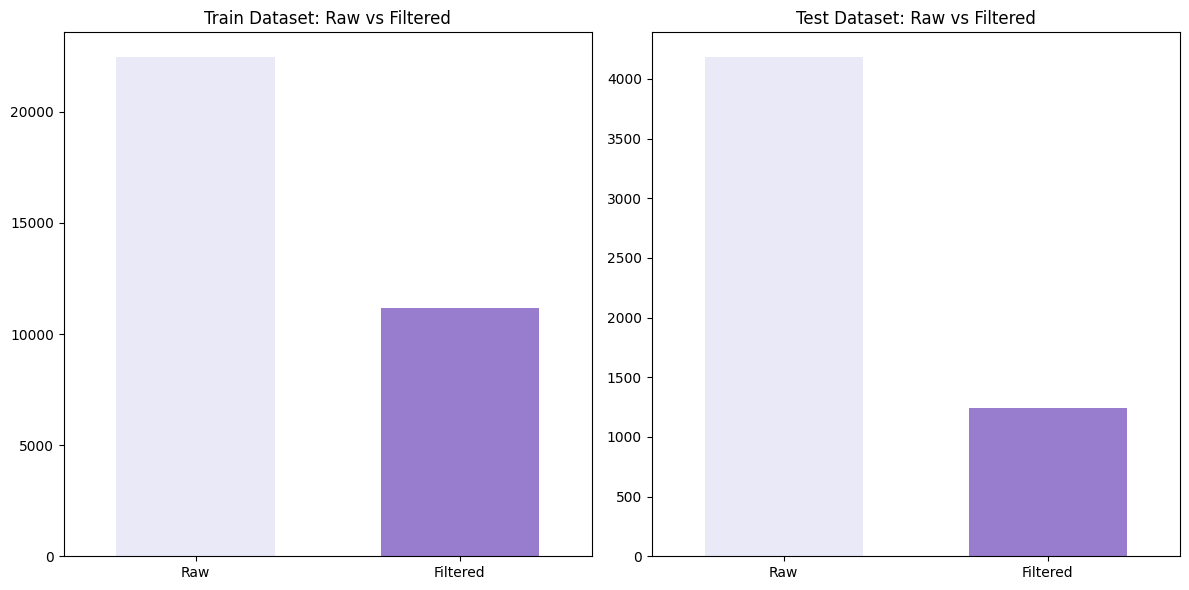

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert datasets to pandas DataFrames
raw_train_df = pd.DataFrame(raw_datasets['train'])
raw_test_df = pd.DataFrame(raw_datasets['test'])
filtered_train_df = pd.DataFrame(filtered_datasets['train'])
filtered_test_df = pd.DataFrame(filtered_datasets['test'])

# Plotting the differences between raw and filtered datasets
# For example, you can compare the number of examples in each dataset
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot number of examples in raw and filtered train datasets
sns.barplot(x=['Raw', 'Filtered'], y=[len(raw_train_df), len(filtered_train_df)], hue=['Raw', 'Filtered'], ax=axes[0], palette=['lavender', 'mediumpurple'], width=0.6, legend=False)
axes[0].set_title('Train Dataset: Raw vs Filtered')

# Plot number of examples in raw and filtered test datasets
sns.barplot(x=['Raw', 'Filtered'], y=[len(raw_test_df), len(filtered_test_df)], hue=['Raw', 'Filtered'], ax=axes[1], palette=['lavender', 'mediumpurple'], width=0.6, legend=False)
axes[1].set_title('Test Dataset: Raw vs Filtered')

plt.tight_layout()
plt.show()


In [ ]:
#print("Context: ", filtered_datasets["train"][2]["context"])
print("Question: ", filtered_datasets["train"][2]["question"])
print("Answer: ", filtered_datasets["train"][2]["answers"])

Question:  Highlight the parts (if any) of this contract related to "Parties" that should be reviewed by a lawyer. Details: The two or more parties who signed the contract
Answer:  {'text': ['Electric City of Illinois L.L.C.'], 'answer_start': [49574]}


____________________


_______


The context and question fields are very straightforward to use. The answers field is a bit trickier as it comports a dictionary with two fields that are both lists.

This is the format that will be expected by the squad metric during evaluation; if you are using your own data, you don’t necessarily need to worry about putting the answers in the same format!!!!. The text field is rather obvious, and the answer_start field contains the starting character index of each answer in the context.

**DO THE SAME TWICE (2)**

HERE I **CHANGED validation from test subset bc we need several possible answers**

In [ ]:
from datasets import DatasetDict
import random
from datasets import load_dataset, Dataset

# Load the original dataset
#filtered_datasets = load_dataset("cuad")

# Shuffle the training dataset
filtered_datasets["train"].shuffle()

# Shuffle the test dataset
filtered_datasets["test"].shuffle()

# Select 128 random examples for training
train_indices = random.sample(range(len(filtered_datasets["train"])), 128)
train_subset = filtered_datasets["train"].select(train_indices)

#test_indices = random.sample(range(len(filtered_datasets["test"])), 128)
#test_subset = rfiltered_datasets["train"].select(train_indices)

valid_indices = random.sample(range(len(filtered_datasets["test"])), 32)
valid_subset = filtered_datasets["test"].select(valid_indices)

# Select 32 random examples for validation
#valid_indices = random.sample(set(range(len(filtered_datasets["train"]))) - set(train_indices), 32)
#valid_subset = filtered_datasets["train"].select(valid_indices)

# Create a dictionary with the small datasets

small_cuad_dataset = {
    "train": train_subset,
    "validation": valid_subset
}

small_cuad_dataset

{'train': Dataset({
     features: ['id', 'title', 'context', 'question', 'answers'],
     num_rows: 128
 }),
 'validation': Dataset({
     features: ['id', 'title', 'context', 'question', 'answers'],
     num_rows: 32
 })}

In [ ]:
#print("Context: ", small_cuad_dataset["train"][0]["context"])
print("Question: ", small_cuad_dataset["train"][0]["question"])
print("Answer: ", small_cuad_dataset["train"][0]["answers"])

#print("Context: ", small_cuad_dataset["validation"][0]["context"])
print("Question: ", small_cuad_dataset["validation"][5]["question"])
print("Answer: ", small_cuad_dataset["validation"][5]["answers"])   # some have only one answer some more!!!

Question:  Highlight the parts (if any) of this contract related to "Minimum Commitment" that should be reviewed by a lawyer. Details: Is there a minimum order size or minimum amount or units per-time period that one party must buy from the counterparty under the contract?
Answer:  {'text': ['Minimum Cumulative Purchase Commitment Contract Year 1 $ [***] $ [***] $ [***] $ [***] Contract Year 2 $ [***] $ [***] $ [***] $ [***] Contract Year 3 $ [***] $ [***] $ [***] $ [***] Contract Year 4 $ [***] $ [***] $ [***] $ [***] Contract Year 5 $ [***] $ [***] $ [***] $ [***] Contract Year 6 $ [***] $ [***] $ [***] $ [***] Contract Year 7 [***] $ [***] $ [***] $ 109,000,000 Total $ [***] $ [***] $150,000,000 N/A'], 'answer_start': [108089]}
Question:  Highlight the parts (if any) of this contract related to "Rofr/Rofo/Rofn" that should be reviewed by a lawyer. Details: Is there a clause granting one party a right of first refusal, right of first offer or right of first negotiation to purchase, l

During training, there is only one possible answer. We can double-check this by using the **Dataset.filter() method:**

In [ ]:
small_cuad_dataset["train"].filter(lambda x: len(x["answers"]["text"]) != 1)

Filter:   0%|          | 0/128 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 0
})

For evaluation, however, there are several possible answers for each sample, which may be the same or different:

In [ ]:
print(small_cuad_dataset["validation"][0]["answers"])
print(small_cuad_dataset["validation"][3]["answers"])  # some have only one answer some more!!!

{'text': ['No Party will make, issue or release any statement which results in any defamation or disparagement of the Village, the City of Canton, the other Party, or any team, person, performer or organization involved in events at the Village.', "Each of the HOF Entities or Constellation may terminate this Agreement at any time without liability if association with another Party could, in such Party's reasonable opinion, materially damage its reputation or image or in the event a Party breaches Section 3.3 hereof, which breach is not cured within sixty (60)."], 'answer_start': [48823, 25953]}
{'text': ['Dova shall bear the out-of-pocket costs and expenses incurred by the Parties in connection with any such inspection or audit, unless the audit shows an undisputed over- payment for that audited period in excess of [***] of the amounts properly determined, in which case, Valeant shall reimburse Dova for its audit fees and reasonable out-of-pocket expenses in connection with said audit,

In [ ]:
print(small_cuad_dataset["validation"][3]["context"])
print(small_cuad_dataset["validation"][3]["question"])

Exhibit 10.2

______________________________________________________________________________

CO-PROMOTION AGREEMENT

by and between

DOVA PHARMACEUTICALS, INC.

and

VALEANT PHARMACEUTICALS NORTH AMERICA LLC

September 26, 2018

______________________________________________________________________________

CONFIDENTIAL TREATMENT HAS BEEN REQUESTED FOR PORTIONS OF THIS EXHIBIT. THE COPY FILED HEREWITH OMITS THE INFORMATION SUBJECT TO A CONFIDENTIALITY REQUEST. OMISSIONS ARE DESIGNATED [***]. A COMPLETE VERSION OF THIS EXHIBIT HAS BEEN FILED SEPARATELY WITH THE SECURITIES AND EXCHANGE COMMISSION.

Source: DOVA PHARMACEUTICALS INC., 10-Q, 11/8/2018





TABLE OF CONTENTS

Page

ARTICLE 1 DEFINITIONS 1

ARTICLE 2 RIGHTS AND OBLIGATIONS 8

2.1 Engagement; Grant of Rights. 8

2.2 Retention of Rights. 9

2.3 Non-Competition; Non-Solicitation. 9

2.4 Dova Trademarks and Copyrights. 10

ARTICLE 3 JOINT STEERING COMMITTEE 11

3.1 Formation of the JSC. 11

3.2 Meetings and Minutes. 11

3.3 Purp

**CHANGED VALIDATION SUBSET!!!!!**

we can see that the answer can indeed be one of the three possibilities we saw before.

In [ ]:
from transformers import RobertaTokenizerFast

model_checkpoint = "roberta-base"
tokenizer = RobertaTokenizerFast.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
tokenizer.is_fast

True

We can pass to our tokenizer the question and the context together, and it will properly insert the special tokens to form a sentence like this:

**< s> question < /s>< /s> context < /s>**

In [ ]:

#print(small_cuad_dataset["train"][0]["question"])
#print(small_cuad_dataset["train"][0]["answers"])

**Achtung!**
Token indices sequence length is longer than the specified maximum sequence length for this model (8933 > 512). Running this sequence through the model will result in indexing errors

In [ ]:
context = small_cuad_dataset["train"][0]["context"]
question = small_cuad_dataset["train"][0]["question"]

inputs = tokenizer(question, context)
tokenizer.decode(inputs["input_ids"])

Token indices sequence length is longer than the specified maximum sequence length for this model (49123 > 512). Running this sequence through the model will result in indexing errors


'<s>Highlight the parts (if any) of this contract related to "Minimum Commitment" that should be reviewed by a lawyer. Details: Is there a minimum order size or minimum amount or units per-time period that one party must buy from the counterparty under the contract?</s></s>Exhibit 10.12\n\n[***] Certain information in this document has been excluded pursuant to Regulation S-K, Item 601(b)(10). Such excluded information is not material and would likely cause competitive harm to the registrant if publicly disclosed.\n\nExecution Version\n\nCOLLABORATION AGREEMENT\n\nThis COLLABORATION AGREEMENT (this "Agreement"), effective as of September 13th, 2019 ("Effective Date"), is between Ginkgo Bioworks, Inc., a Delaware corporation with offices located at 27 Drydock Avenue, 8th floor, Boston, Massachusetts 02210 ("Ginkgo"), and Berkeley Lights, Inc., a Delaware corporation with offices located at 5858 Horton Street, Suite 320, Emeryville, California 94608 ("BLI"). Ginkgo and BLI may each be re

In [ ]:
inputs = tokenizer(
    question,
    context,
    max_length=512, # I changed from 100 to 512
    truncation="only_second", # to truncate the context (which is in the second position) when the question with its context is too long
    stride=50, # to set the number of overlapping tokens between two successive chunks (here 50)
    return_overflowing_tokens=True, # to let the tokenizer know we want the overflowing tokens
)

for ids in inputs["input_ids"]:
    print(tokenizer.decode(ids))



<s>Highlight the parts (if any) of this contract related to "License Grant" that should be reviewed by a lawyer. Details: Does the contract contain a license granted by one party to its counterparty?</s></s>Exhibit 10.1   COLLABORATION AGREEMENT   by and between   THERAVANCE, INC.   and   GLAXO GROUP LIMITED   Dated: November 14, 2002





  TABLE OF CONTENTS                                                ARTICLE 1 DEFINITIONS   1           ARTICLE 2 RIGHTS AND OBLIGATIONS   11   2.1 License Grants from Theravance to GSK   11   2.1.1 Development License   11   2.1.2 Commercialization License   11   2.1.3 Manufacturing License   11   2.2 Sublicensing and Subcontracting   11   2.3 Trademarks and Housemarks   12   2.3.1 Trademarks   12   2.3.2 Housemarks   12   2.3.3 Ownership of Inventions   12           ARTICLE 3 GOVERNANCE OF DEVELOPMENT AND COMMERCIALIZATION OF PRODUCTS   13   3.1 Joint Steering Committee   13   3.1.1 Purpose   13   3.1.2 Members; Officers   13   3.1.3 Responsibilitie

As we can see, our example has been in **split into 22 inputs**, each of them containing the question and some part of the context. (TRY CtrlF "..Highlight the parts")

 the question (“Bernadette Soubirous”) only appears in the 7th inputs, so by dealing with long contexts in this way we will create some training examples where the answer is not included in the context. For those examples, the labels will be start_position = end_position = 0 <s>(so we predict the [CLS] token).</s> We will also set those labels in the unfortunate case where the answer has been truncated so that we only have the start (or end) of it. For the examples where the answer is fully in the context, the labels will be the index of the token where the answer starts and the index of the token where the answer ends.

 The dataset provides us with the start character of the answer in the context, and by adding the length of the answer, we can find the end character in the context. To map those to token indices, we will need to use the offset mappings we studied in Chapter 6. We can have our tokenizer return these by passing along return_offsets_mapping=True:




In [ ]:
inputs = tokenizer(
    question,
    context,
    max_length=512,
    truncation="only_second",
    stride=100, #50 to 100
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
)
inputs.keys()

dict_keys(['input_ids', 'attention_mask', 'offset_mapping', 'overflow_to_sample_mapping'])

As we can see, we get back the usual input IDs, token type IDs, and attention mask, as well as the offset mapping we required and an extra key, overflow_to_sample_mapping. The corresponding value will be of use to us when we tokenize several texts at the same time (which we should do to benefit from the fact that our tokenizer is backed by Rust). Since one sample can give several features, it maps each feature to the example it originated from. Because here we only tokenized one example, we get a list of 0s:

In [ ]:
inputs["overflow_to_sample_mapping"] # we get 22

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

But if we tokenize more examples, this will become more useful:

In [ ]:
inputs = tokenizer(
    small_cuad_dataset["train"][2:6]["question"],
    small_cuad_dataset["train"][2:6]["context"],
    max_length=512, # I changed from 100 to 512
    truncation="only_second",
    stride=100, #50 to 100
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
)

print(f"The 4 examples gave {len(inputs['input_ids'])} features.")
print(f"Here is where each comes from: {inputs['overflow_to_sample_mapping']}.")

The 4 examples gave 149 features.
Here is where each comes from: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3].


As we can see, <s>the first three examples (at indices 2, 3, and 4 in the training set) each gave 55 features and the last example (at index 5 in the training set) gave 7 features.</s>

at indices 2 gave 99 features, at indices 3 gave 51 features, at indices 4 gave 10 features, at indices 4 gave 27 features.

This information will be useful to map each feature we get to its corresponding label. As mentioned earlier, those labels are:

*   (0, 0) if the answer is not in the corresponding span of the context
*   (start_position, end_position) if the answer is in the corresponding span of the context, with start_position being the index of the token (in the input IDs) at the start of the answer and end_position being the index of the token (in the input IDs) where the answer ends

To determine which of these is the case and, if relevant, the positions of the tokens, we first find the indices that start and end the context in the input IDs. We could use the token type IDs to do this, but since those do not necessarily exist for all models (DistilBERT does not require them, for instance), we’ll instead use the **sequence_ids()** method of the BatchEncoding our tokenizer returns.

Once we have those token indices, we look at the corresponding offsets, which are tuples of two integers representing the span of characters inside the original context. We can thus detect if the chunk of the context in this feature starts after the answer or ends before the answer begins (in which case the label is (0, 0)). If that’s not the case, we loop to find the first and last token of the answer:



**ACHTUNG!** I think the problem is that our dataset has "answers" that look like this:

{ "text": [], "answer_start": [] }

In [ ]:
answers = small_cuad_dataset["train"][2:6]["answers"] #2:6 --: 1,2,4,7,8 SEE the PROBLEM down
start_positions = []
end_positions = []

for i, offset in enumerate(inputs["offset_mapping"]):
    sample_idx = inputs["overflow_to_sample_mapping"][i]
    answer = answers[sample_idx]
    start_char = answer["answer_start"][0]
    end_char = answer["answer_start"][0] + len(answer["text"][0])
    sequence_ids = inputs.sequence_ids(i)

    # Find the start and end of the context
    idx = 0
    while sequence_ids[idx] != 1:
        idx += 1
    context_start = idx
    while sequence_ids[idx] == 1:
        idx += 1
    context_end = idx - 1

    # If the answer is not fully inside the context, label is (0, 0)
    if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
        start_positions.append(0)
        end_positions.append(0)
    else:
        # Otherwise it's the start and end token positions
        idx = context_start
        while idx <= context_end and offset[idx][0] <= start_char:
            idx += 1
        start_positions.append(idx - 1)

        idx = context_end
        while idx >= context_start and offset[idx][1] >= end_char:
            idx -= 1
        end_positions.append(idx + 1)

start_positions, end_positions

([0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  234,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  427,
  53,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  239,
  0,
  0,
  116,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


Answer:  {'text': ['DISTRIBUTOR AGREEMENT'], 'answer_start': [44]}

**PROBLEM:** When I run again it changes!

**ACHTUNG!** I think the problem is that our dataset has "answers" that look like this:

{ "text": [], "answer_start": [] }

In [ ]:
#print("Answer: ", small_cuad_dataset["train"][0]["answers"]) #Nothing 0, 3, 5,6,9 ok:1,2,4,7,8
print("Answer: ", small_cuad_dataset["train"][9]["answers"]) #Nothing 0, 3, 5,6,9 ok:1,2,5,6,9

Answer:  {'text': ["In the event of the termination of this Agreement for any reason whatsoever, the exclusive distribution right and license granted to Distributor pursuant to this Agreement shall automatically revert to Vendor as Vendor's sole property."], 'answer_start': [4605]}




---

In HF tutorial:

([83, 51, 19, 0, 0, 64, 27, 0, 34, 0, 0, 0, 67, 34, 0, 0, 0, 0, 0],

 [85, 53, 21, 0, 0, 70, 33, 0, 40, 0, 0, 0, 68, 35, 0, 0, 0, 0, 0])

 Let’s take a look at a few results to verify that our approach is correct. For the first feature we find (83, 85) as labels, so let’s compare the theoretical answer with the decoded span of tokens from 83 to 85 (inclusive):

 ((In our case its from 145 to 223))

In [ ]:
idx = 1 #Set to79!!!!
sample_idx = inputs["overflow_to_sample_mapping"][idx]
answer = answers[sample_idx]["text"][0]

start = start_positions[idx]
end = end_positions[idx]
labeled_answer = tokenizer.decode(inputs["input_ids"][idx][start : end + 1])

print(f"Theoretical answer: {answer}, labels give: {labeled_answer}")

Theoretical answer: Once a Delivery of Miltenyi Products is accepted or deemed accepted hereunder, Bellicum shall have no recourse against Miltenyi in the event any such Miltenyi Product is subsequently deemed unsuitable for use for any reason, except for Miltenyi Product that does not conform to the Miltenyi Product Warranty after said 30-day period due to a latent defect in the Miltenyi Product that could not be detected through the performance of the Testing Methods., labels give: <s>


So that’s a match! Now let’s check index 4, where we set the labels to (0, 0), which means the answer is not in the context chunk of that feature:

In [ ]:
idx = 0 #set to idx where (0,0)
sample_idx = inputs["overflow_to_sample_mapping"][idx]
answer = answers[sample_idx]["text"][0]

decoded_example = tokenizer.decode(inputs["input_ids"][idx])
print(f"Theoretical answer: {answer}, decoded example: {decoded_example}")

Theoretical answer: Once a Delivery of Miltenyi Products is accepted or deemed accepted hereunder, Bellicum shall have no recourse against Miltenyi in the event any such Miltenyi Product is subsequently deemed unsuitable for use for any reason, except for Miltenyi Product that does not conform to the Miltenyi Product Warranty after said 30-day period due to a latent defect in the Miltenyi Product that could not be detected through the performance of the Testing Methods., decoded example: <s>Highlight the parts (if any) of this contract related to "Warranty Duration" that should be reviewed by a lawyer. Details: What is the duration of any  warranty against defects or errors in technology, products, or services  provided under the contract?</s></s>Exhibit 10.1 [***] = Certain confidential information contained in this document, marked by brackets, has been omitted because it is both (i) not material and (ii) would likely be competitively harmful if publicly disclosed.

Miltenyi Biotec-B

Indeed, we don’t see the answer inside the context.

Now that we have seen step by step how to preprocess our training data, we can group it in a function we will apply on the whole training dataset. We’ll pad every feature to the maximum length we set, as most of the contexts will be long (and the corresponding samples will be split into several features), so there is no real benefit to applying dynamic padding here:

In [ ]:
max_length = 512
stride = 100


def preprocess_training_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = answers[sample_idx]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label is (0, 0)
        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

Note that we defined two constants to determine the maximum length used as well as the length of the sliding window, and that we added a tiny bit of cleanup before tokenizing: some of the questions in the SQuAD dataset have extra spaces at the beginning and the end that don’t add anything (and take up space when being tokenized if you use a model like RoBERTa), so we removed those extra spaces.

To apply this function to the whole training set, we use the **Dataset.map()** method with the batched=True flag. It’s necessary here as we are changing the length of the dataset (since one example can give several training features):

In [ ]:
train_dataset = small_cuad_dataset["train"].map(
    preprocess_training_examples,
    batched=True,
    remove_columns=small_cuad_dataset["train"].column_names,
)
len(small_cuad_dataset["train"]), len(train_dataset)

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

(128, 7598)

As we can see, the preprocessing added roughly <s>1,000</s> 8569 features. Our training set is now ready to be used — let’s dig into the preprocessing of the validation set!

**Processing the validation data**

Preprocessing the validation data will be slightly easier as we don’t need to generate labels (unless we want to compute a validation loss, but that number won’t really help us understand how good the model is). The real joy will be to interpret the predictions of the model into spans of the original context. For this, we will just need to store both the offset mappings and some way to match each created feature to the original example it comes from. Since there is an ID column in the original dataset, we’ll use that ID.

The only thing we’ll add here is a tiny bit of cleanup of the offset mappings. They will contain offsets for the question and the context, but once we’re in the post-processing stage we won’t have any way to know which part of the input IDs corresponded to the context and which part was the question (the **sequence_ids() **method we used is available for the output of the tokenizer only). So, we’ll set the offsets corresponding to the question to None:

In [ ]:
def preprocess_validation_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples["id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs["example_id"] = example_ids
    return inputs

We can apply this function on the whole validation dataset like before:

In [ ]:
validation_dataset = small_cuad_dataset["validation"].map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=small_cuad_dataset["validation"].column_names,
)
len(small_cuad_dataset["validation"]), len(validation_dataset)

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

(32, 1548)

<s>In this case we’ve only added a couple of hundred samples, so it appears the contexts in the validation dataset are a bit shorter.

Now that we have preprocessed all the data, we can get to the training.

# **Fine-tuning the model with the Trainer API**